‚úÖ Merge final com 2556 linhas.
üíæ Base final salva em: saida/base_completa_merge.csv


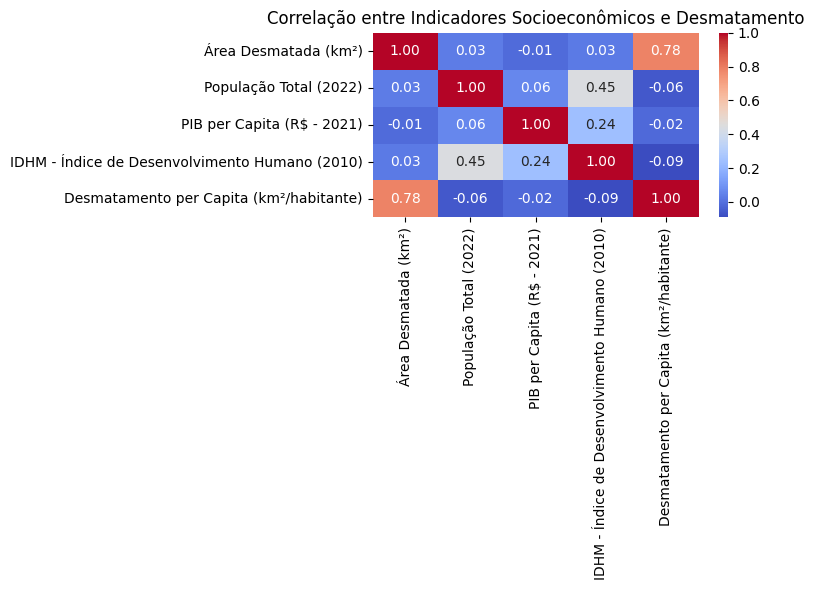

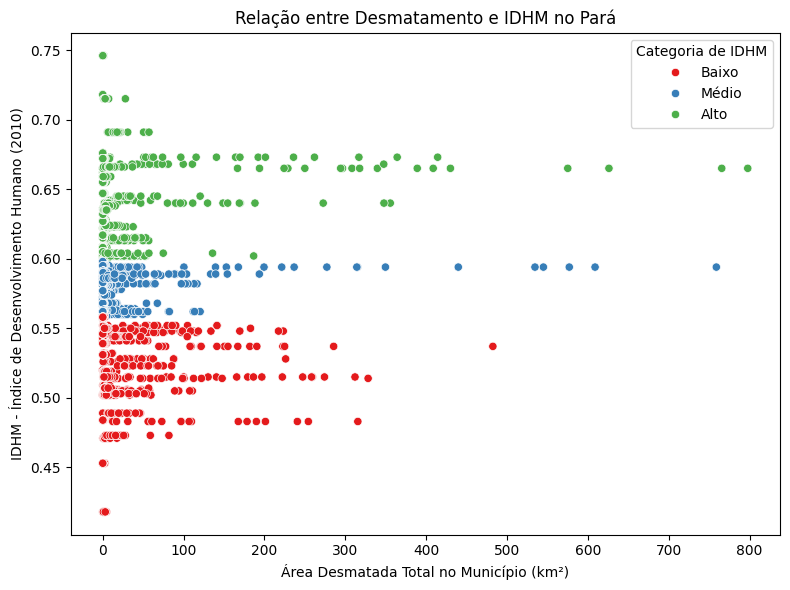

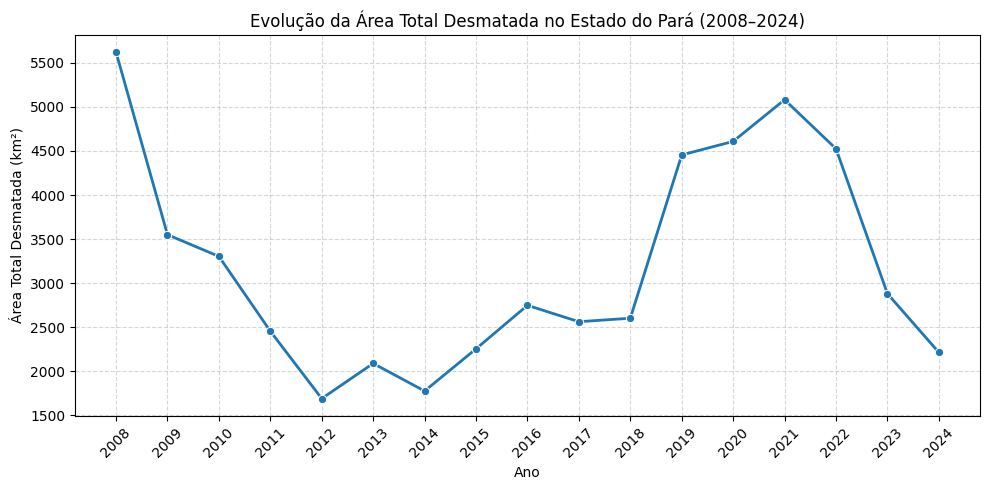


üìä M√©dias por Categoria de IDHM:
           √Årea Desmatada (km¬≤)  PIB per Capita (R$ - 2021)  \
idhm_cat                                                     
Baixo                    26.43                    14668.37   
M√©dio                    17.34                    15617.23   
Alto                     23.62                    48740.69   

          Popula√ß√£o Total (2022)  
idhm_cat                          
Baixo                   34168.74  
M√©dio                   29377.17  
Alto                   107265.36  


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================
# 1. Leitura e tratamento dos dados do IBGE
# =============================================

arquivo_ibge = 'dados/ibge_para_2024.xlsx'
dados_ibge = pd.read_excel(arquivo_ibge, skiprows=0, nrows=144)

dados_ibge.columns = [
    'municipio', 'codigo_ibge', 'gentilico', 'prefeito', 'area_km2', 'populacao_2022',
    'densidade_2022', 'populacao_estimada_2024', 'escolarizacao_6a14_2010',
    'idhm_2010', 'mortalidade_infantil_2022', 'receitas_2022', 'despesas_2022',
    'pib_per_capita_2021'
]

dados_ibge['codigo_ibge'] = pd.to_numeric(dados_ibge['codigo_ibge'], errors='coerce').astype('Int64')

# Convers√£o de colunas num√©ricas
colunas_numericas = [
    'area_km2', 'populacao_2022', 'densidade_2022', 'populacao_estimada_2024',
    'escolarizacao_6a14_2010', 'idhm_2010', 'mortalidade_infantil_2022',
    'receitas_2022', 'despesas_2022', 'pib_per_capita_2021'
]
for col in colunas_numericas:
    dados_ibge[col] = pd.to_numeric(dados_ibge[col], errors='coerce')

# Remover entradas essenciais ausentes
dados_ibge = dados_ibge.dropna(subset=['codigo_ibge', 'municipio', 'populacao_2022', 'pib_per_capita_2021'])


# =============================================
# 2. Leitura dos dados do INPE corrigidos
# =============================================

arquivo_inpe = 'dados/desmatamento_para_2007_2024.csv'
dados_inpe = pd.read_csv(arquivo_inpe, sep=';')
dados_inpe.columns = dados_inpe.columns.str.strip().str.lower()

dados_inpe['year'] = pd.to_numeric(dados_inpe['year'], errors='coerce')
dados_inpe['areakm'] = pd.to_numeric(dados_inpe['areakm'], errors='coerce')
dados_inpe['geocode_ibge'] = pd.to_numeric(dados_inpe['geocode_ibge'], errors='coerce').astype('Int64')


# =============================================
# 3. Merge das duas bases pelo c√≥digo IBGE
# =============================================

dados_merged = pd.merge(
    dados_inpe,
    dados_ibge,
    left_on='geocode_ibge',
    right_on='codigo_ibge',
    how='inner'
)

print(f"‚úÖ Merge final com {dados_merged.shape[0]} linhas.")

# Novo indicador: desmatamento per capita
dados_merged['desmatamento_per_capita'] = dados_merged['areakm'] / dados_merged['populacao_2022']

# Categorizar IDHM (ter√ßo inferior, m√©dio e superior)
if dados_merged['idhm_2010'].dropna().nunique() >= 3:
    dados_merged['idhm_cat'] = pd.qcut(
        dados_merged['idhm_2010'], q=3, labels=['Baixo', 'M√©dio', 'Alto']
    )
else:
    dados_merged['idhm_cat'] = 'N√£o classificado'

# Salvar a base final
os.makedirs('saida', exist_ok=True)
dados_merged.to_csv('saida/base_completa_merge.csv', index=False)
print("üíæ Base final salva em: saida/base_completa_merge.csv")


# =============================================
# 4. Visualiza√ß√µes (removendo o ano de 2007)
# =============================================

# =============================================
# 4. Visualiza√ß√µes (com t√≠tulos e r√≥tulos melhores)
# =============================================

# üîé Remover o ano de 2007 (valores acumulados incomuns)
dados_filtrados = dados_merged[dados_merged['year'] > 2007].copy()

# üîÅ Dicion√°rio para tornar as vari√°veis mais leg√≠veis nos gr√°ficos
label_map = {
    'areakm': '√Årea Desmatada (km¬≤)',
    'populacao_2022': 'Popula√ß√£o Total (2022)',
    'pib_per_capita_2021': 'PIB per Capita (R$ - 2021)',
    'idhm_2010': 'IDHM - √çndice de Desenvolvimento Humano (2010)',
    'desmatamento_per_capita': 'Desmatamento per Capita (km¬≤/habitante)'
}

# üî¨ Correla√ß√£o entre vari√°veis
plt.figure(figsize=(8, 6))
correlacao = dados_filtrados[[
    'areakm', 'populacao_2022', 'pib_per_capita_2021',
    'idhm_2010', 'desmatamento_per_capita'
]].corr()
correlacao.rename(index=label_map, columns=label_map, inplace=True)

sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correla√ß√£o entre Indicadores Socioecon√¥micos e Desmatamento")
plt.tight_layout()
plt.show()

# üìâ Dispers√£o entre desmatamento e IDHM
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=dados_filtrados,
    x='areakm', y='idhm_2010', hue='idhm_cat', palette='Set1'
)
plt.xlabel("√Årea Desmatada Total no Munic√≠pio (km¬≤)")
plt.ylabel("IDHM - √çndice de Desenvolvimento Humano (2010)")
plt.title("Rela√ß√£o entre Desmatamento e IDHM no Par√°")
plt.legend(title='Categoria de IDHM')
plt.tight_layout()
plt.show()

# üìà Evolu√ß√£o do desmatamento ao longo dos anos
df_evolucao = dados_filtrados.groupby('year')['areakm'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_evolucao, x='year', y='areakm', marker='o', linewidth=2)
plt.title("Evolu√ß√£o da √Årea Total Desmatada no Estado do Par√° (2008‚Äì2024)")
plt.xlabel("Ano")
plt.ylabel("√Årea Total Desmatada (km¬≤)")
plt.xticks(df_evolucao['year'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# üßæ Tabela resumo por categoria de IDHM
resumo = dados_filtrados.groupby('idhm_cat', observed=True)[[
    'areakm', 'pib_per_capita_2021', 'populacao_2022'
]].mean().rename(columns=label_map)

print("\nüìä M√©dias por Categoria de IDHM:\n", resumo.round(2))
